In [86]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from pathlib import Path
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from numpy import *

Text(0.5, 1.0, 'Unemployed Rate from 2010 to 2023 in Malaysia')

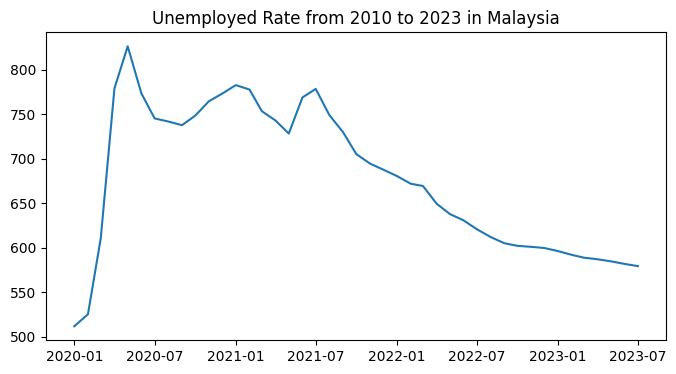

In [87]:
# import data set
data_dir = Path('../datathon')

# read data set
df = pd.read_csv(data_dir / 'labourforce_monthly.csv', parse_dates=['date'])
df.head()

# remove the empty columns
df = df.dropna(axis=1, how='all')

# Remove all the unnecessary columns only left the date and unemployed columns
df = df[['date', 'unemployed']]

# set the data start from 2020-01-01
df = df[df['date'] >= '2020-01-01']

# plot the data set
fig, ax = plt.subplots(figsize=(8, 4))
plt.plot(df.date, df.unemployed, label='train')

# add title and legend to the plot
plt.title('Unemployed Rate from 2010 to 2023 in Malaysia')

In [88]:
df.index = df.date

# remove date
df = df.drop(['date'], axis=1)
df

,unemployed
date,
2020-01-01,511.687
2020-02-01,525.228
2020-03-01,610.537
2020-04-01,778.790
2020-05-01,826.100
2020-06-01,773.247
2020-07-01,745.100
2020-08-01,741.600
2020-09-01,737.500


# 3. Test for Data Set
## 3.1 Stationary Test

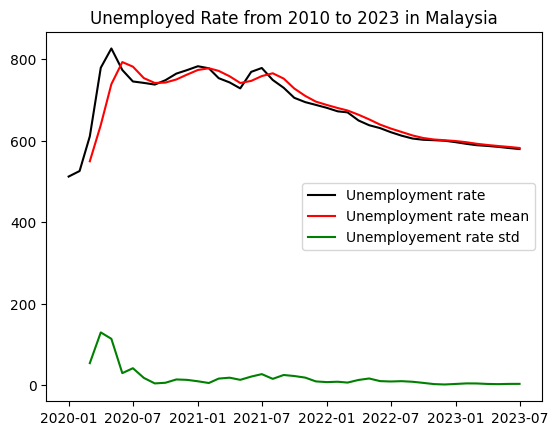

In [89]:
# perform the stationarity test
unemployed_mean = df.unemployed.rolling(3).mean()
unemployed_std = df.unemployed.rolling(3).std()
plt.plot(df.unemployed, color = "black", label='Unemployment rate')
plt.plot( unemployed_mean, color = "red", label='Unemployment rate mean')
plt.plot(unemployed_std, color = "green", label='Unemployement rate std')
plt.title('Unemployed Rate from 2010 to 2023 in Malaysia')
plt.legend(loc = "best")

In [90]:
# perform the stationarity test
adft = adfuller(df.unemployed, autolag='AIC')
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

      Values                       Metric
0  -1.877542              Test Statistics
1   0.342699                      p-value
2   9.000000             No. of lags used
3  33.000000  Number of observations used
4  -3.646135          critical value (1%)
5  -2.954127          critical value (5%)
6  -2.615968         critical value (10%)


## 3.2 Autocorrelation

In [91]:
autocorrelation_lag1 = df.unemployed.autocorr(lag=1)
print("One Month Lag: ", autocorrelation_lag1)

autocorrelation_lag3 = df.unemployed.autocorr(lag=3)
print("Three Month Lag: ", autocorrelation_lag3)

autocorrelation_lag6 = df.unemployed.autocorr(lag=6)
print("Six Month Lag: ", autocorrelation_lag6)

autocorrelation_lag9 = df.unemployed.autocorr(lag=9)
print("Nine Month Lag: ", autocorrelation_lag9)

One Month Lag:  0.9105394629146206
Three Month Lag:  0.5285912574918196
Six Month Lag:  0.5742808947031518
Nine Month Lag:  0.3552548536907968


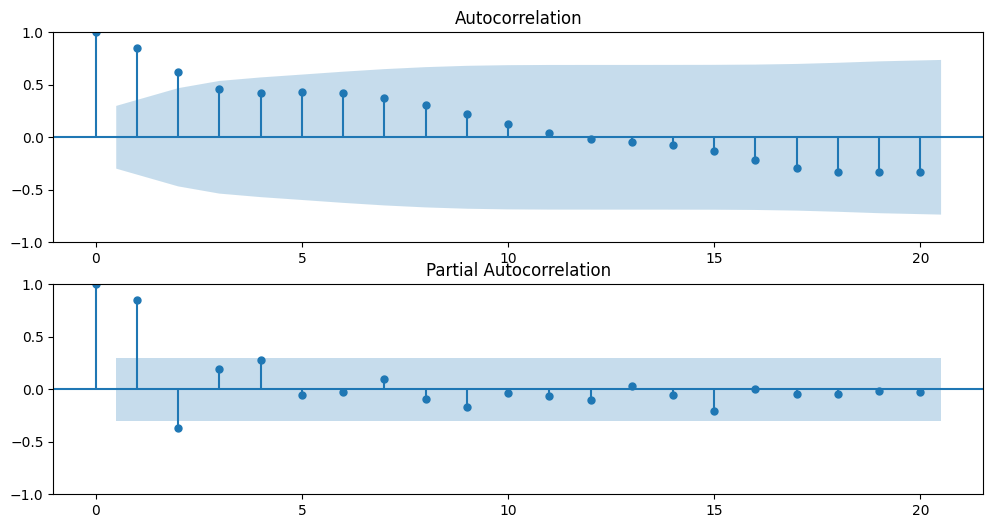

In [92]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(df.dropna(), ax=ax[1], lags=20)

## 3.3 Decomposition

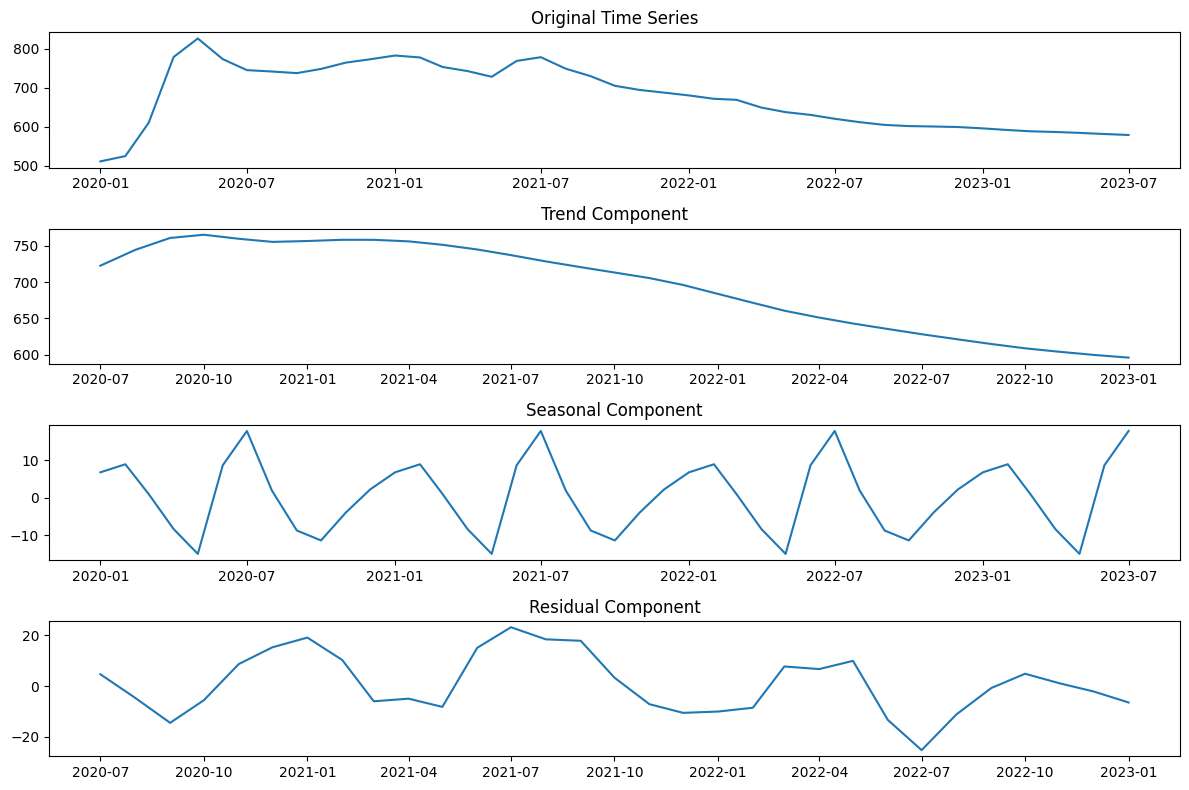

In [93]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df, model='additive')
trend = result.trend
seasonal = result.seasonal
residual = result.resid

plt.figure(figsize=(12, 8))

# Original time series
plt.subplot(411)
plt.plot(df)
plt.title('Original Time Series')

# Trend component
plt.subplot(412)
plt.plot(trend)
plt.title('Trend Component')

# Seasonal component
plt.subplot(413)
plt.plot(seasonal)
plt.title('Seasonal Component')

# Residual component
plt.subplot(414)
plt.plot(residual)
plt.title('Residual Component')

plt.tight_layout()
plt.show()


# 4. Data Transformation

      Values                       Metric
0  -3.498589              Test Statistics
1   0.008023                      p-value
2   0.000000             No. of lags used
3  41.000000  Number of observations used
4  -3.600983          critical value (1%)
5  -2.935135          critical value (5%)
6  -2.605963         critical value (10%)


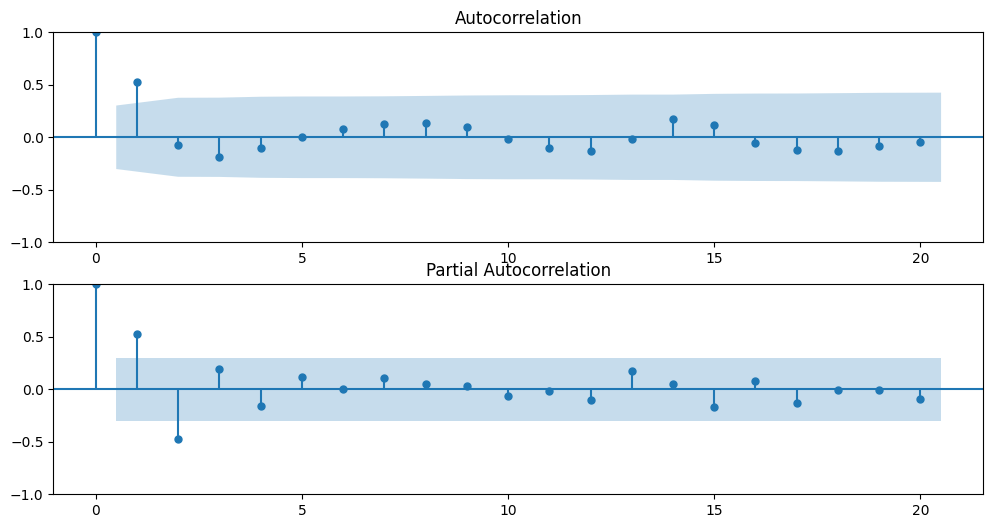

In [94]:
df_diff = df.diff().dropna()


# perform the stationarity test
adft = adfuller(df_diff.unemployed, autolag='AIC')
output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

# autocorrelation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, figsize=(12,6))
ax[0] = plot_acf(df_diff.dropna(), ax=ax[0], lags=20)
ax[1] = plot_pacf(df_diff.dropna(), ax=ax[1], lags=20)

# 5. Fitting the Model

## ETS

In [95]:
# split the data set into train and test
train_diff = df[:len(df)-12]
test_diff = df[len(df)-12:]
train_diff.shape, test_diff.shape

((31, 1), (12, 1))

In [96]:
diff = len(train_diff)- len(test_diff)
model = ExponentialSmoothing(train_diff)  
model_fit = model.fit()
forecasts = model_fit.forecast(steps= 19)

c:\Users\TAN YU JING\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


### ETS Accuracy Testing

In [97]:
mae = mean_absolute_error(test_diff, forecast)
mse = mean_squared_error(test_diff, forecast)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 54.62
Mean Squared Error (MSE): 3428.81
Root Mean Squared Error (RMSE): 58.56


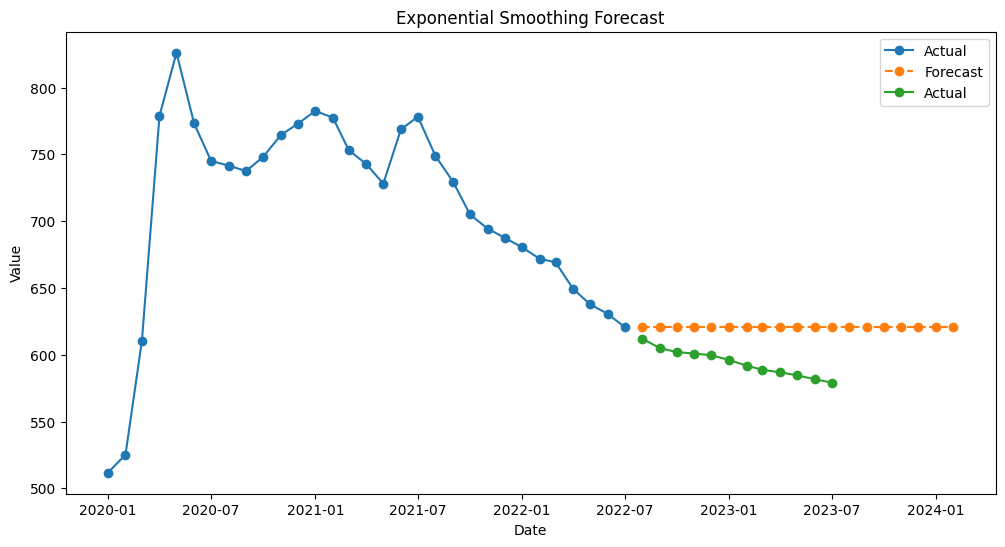

In [98]:
plt.figure(figsize=(12, 6))
plt.plot(train_diff, label='Actual', linestyle='-', marker='o')
plt.plot(forecasts, label='Forecast', linestyle='--', marker='o')
plt.plot(test_diff, label='Actual', linestyle='-', marker='o') 
plt.legend()
plt.title('Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()



## ARIMA test

Performing stepwise search to minimize aic


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.68 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=358.494, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=322.934, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.00 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=497.300, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=310.340, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=308.584, Time=0.20 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=322.021, Time=0.45 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=308.499, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=306.519, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=306.404, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=306.950, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=314.369, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=310.055, Time=0.02 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 2.025 seconds


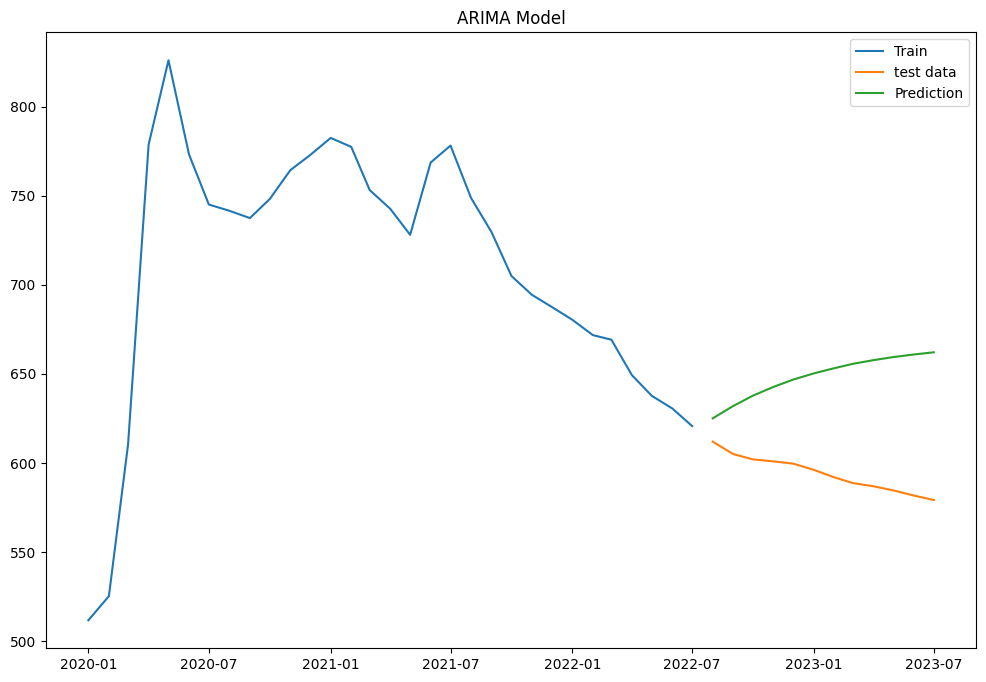

In [99]:
model = auto_arima(train_diff, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_diff)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test.index,columns=['Prediction'])
# plot the predictions for validation set
plt.figure(figsize=(12,8))
plt.plot(train_diff, label='Train')
plt.plot(test_diff, label='test data')
plt.plot(forecast, label='Prediction')
plt.title('ARIMA Model')
plt.legend(loc='best')

### ARIMA Accuracy Testing

In [100]:
rms = sqrt(mean_squared_error(test_diff.unemployed,forecast))
print("RMSE: ", rms)

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_diff.unemployed, forecast)
print("MAE: ", mae)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(test_diff.unemployed, forecast)
print("MAPE: ", mape)

RMSE:  58.55605666139828
MAE:  54.62457104108167
MAPE:  9.224468291642312
